In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt
from scipy.integrate import solve_ivp
from scipy.optimize import OptimizeResult

from throttle_function import throttle_tanh
from dynamics import LowThrustTwoBodyMEOE
from units import *
from state import Index as I
from meoe import *

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
MU = 132712440018  # km^3/s^2
g0 = 9.8065e-3  # km/s^2
m0 = 4000  # kg
Tmax = 0.32e-3  # kN
Isp = 3000  # s

rv0 = np.array([
    -3637871.081, 147099798.784, -2261.441,
    -30.265097, -0.8486854, 0.0000505
])  # [km] and [km/s]

# t0 = 56284 * 86400  # MJD * sec
t0 = 0  # MJD * sec
dt = 3534 * 86400 / TU
tn = t0 + dt

# normalize
rv0[:3] /= DU
rv0[3:] /= (DU / TU)
m0 /= MaU
MU /= (DU ** 3 / TU ** 2)
Tmax /= (MaU * DU / TU ** 2)
Isp /= TU
g0 /= (DU / TU ** 2)

mee0 = np.array(from_cartesian(rv0, MU))

np.random.seed(0)
costate = np.random.rand(7) * 0.1
# costate = np.zeros(7)
x0 = np.r_[mee0, m0, costate]
print(x0)

[ 9.99708536e-01 -3.76678695e-03  1.62868327e-02 -7.70205129e-06
  6.18315849e-07  7.87870723e+00  1.00000000e+00  5.48813504e-02
  7.15189366e-02  6.02763376e-02  5.44883183e-02  4.23654799e-02
  6.45894113e-02  4.37587211e-02]


In [3]:
dyn = LowThrustTwoBodyMEOE(
    mu=MU, thrust_max=Tmax, Isp=Isp, g0=g0, rho=1 
)
print(dyn.time_derivative(t0, x0))

[ 4.80031162e-03  6.63644822e-04  4.89824363e-03 -2.66428566e-06
  1.07732208e-04  1.03345038e+00 -2.60734984e-03  9.95852166e-02
  3.06567283e-03 -1.31050358e-01 -1.36167543e-05 -3.36758096e-07
 -1.27410573e-04 -6.10577790e-04]


In [4]:
# %%timeit
# dyn.time_derivative(t0, x0)
# 48.2 µs ± 982 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
# 7.62 µs ± 8.08 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

7.67 µs ± 10 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [5]:
sol = solve_ivp(
    dyn.time_derivative, (t0, tn), x0,
    method='DOP853', rtol=1e-9, atol=1e-9,
    t_eval=np.linspace(t0, tn, 10000)
)

In [6]:
def shooting(rv_f, lmf, rv_t):
    drv = rv_f - rv_t
    return np.array([*drv, lmf])

rv_t = np.array([
    -1.26725023, 3.09190622, 0.40526029, 
    -0.3132259 , -0.19178898, 0.0687792
])

def evaluate_sol(costate0, dense=False):
    x0 = np.r_[mee0, m0, costate0]
    sol = solve_ivp(
        dyn.time_derivative, (t0, tn), x0,
        method='DOP853', rtol=1e-9, atol=1e-9,
        t_eval=np.linspace(t0, tn, 10000) if dense else None
    )
    n = sol.t.shape[0]
    mee = sol.y[I.mee]
    rv = np.array([
        to_cartesian(mee[:, i], MU) for i in range(n)
    ]).T
    sol.rv = rv
    return sol

def objective(costate0):
    sol = evaluate_sol(costate0)
    rv = sol.rv
    lm = sol.y[I.lm].ravel()
    obj_val = shooting(rv[:, -1], lm[-1], rv_t)
    # print(obj_val)
    return obj_val

def obj_scalar(costate0):
    obj = objective(costate0)
    return 0.5 * obj @ obj

def evaluate_auxiliary(sol):
    # evaluate the auxiliary variables from integration results
    n = sol.t.shape[0]
    mee = sol.y[I.mee]
    m = sol.y[I.m].ravel()  # (n, )
    lambda_el = sol.y[I.l_mee]
    lambda_m = sol.y[I.lm].ravel()
    p = np.array([
        AB(mee[:, i], MU)[1].T @ lambda_el[:, i] for i in range(n)
    ])
    sf = dyn.c * norm(p, axis=1) / m + lambda_m - 1
    u_tanh = throttle_tanh(sf, dyn.rho)
    u = 0.5 * (1 + np.sign(sf))
    sol_aux = OptimizeResult(
        t=sol.t, sf=sf, u_tanh=u_tanh, u=u,
    )
    return sol_aux

In [8]:
# %%timeit
# objective(costate)
# 59.5 ms ± 198 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 12 ms ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

11.7 ms ± 18 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
dyn.rho = 1e-3
# x0 = np.random.rand(7) * 2 - 1
x0 = msol.x
objective(x0)

array([ 2.97059748e-03,  1.84198183e-03,  3.32385352e-04, -7.00962340e-05,
        5.76769291e-04,  3.46174455e-04, -3.97480112e-04])

In [17]:
%%time
def print_callback(x, convergence):
    x_str = np.array2string(x, separator=', ', formatter={'float': '{:.2e}'.format})
    print(f'x: {x_str}, f(x): {obj_scalar(x):.4e}')

msol = opt.differential_evolution(
    obj_scalar, bounds=[(-1, 1)] * 7,
    # callback=print_callback,
    disp=True, x0=x0,
    workers=-1, updating='deferred', recombination=0.7,
)

differential_evolution step 1: f(x)= 6.47161e-06
differential_evolution step 2: f(x)= 6.47161e-06
differential_evolution step 3: f(x)= 6.47161e-06
differential_evolution step 4: f(x)= 6.47161e-06
differential_evolution step 5: f(x)= 6.47161e-06
differential_evolution step 6: f(x)= 6.47161e-06
differential_evolution step 7: f(x)= 6.47161e-06
differential_evolution step 8: f(x)= 6.47161e-06
differential_evolution step 9: f(x)= 6.47161e-06
differential_evolution step 10: f(x)= 6.47161e-06
differential_evolution step 11: f(x)= 6.47161e-06
differential_evolution step 12: f(x)= 6.47161e-06
differential_evolution step 13: f(x)= 6.47161e-06
differential_evolution step 14: f(x)= 6.47161e-06
differential_evolution step 15: f(x)= 6.47161e-06
differential_evolution step 16: f(x)= 6.47161e-06
differential_evolution step 17: f(x)= 6.47161e-06
differential_evolution step 18: f(x)= 6.47161e-06
differential_evolution step 19: f(x)= 6.47161e-06
differential_evolution step 20: f(x)= 6.47161e-06
different

In [18]:
x_best = msol.x
print(x_best)
sval = objective(x_best)
sval[:3] *= DU
sval[3:6] *= (DU / TU)
print(f"drf: {sval[:3]} km")
print(f"dvf: {sval[3:6]} km/s")
print(f"lmf: {sval[6]}")

[ 0.13365686  0.05011865 -0.19747523  0.19549738  0.54435997  0.00296076
  0.38848528]
drf: [14.9042328  -6.55090492 -9.1883583 ] km
dvf: [-1.57471376e-06 -3.40949256e-06  5.03573715e-06] km/s
lmf: 1.0100555139892165e-07


In [19]:
sol = evaluate_sol(x_best, dense=True)
sol_ax = evaluate_auxiliary(sol)

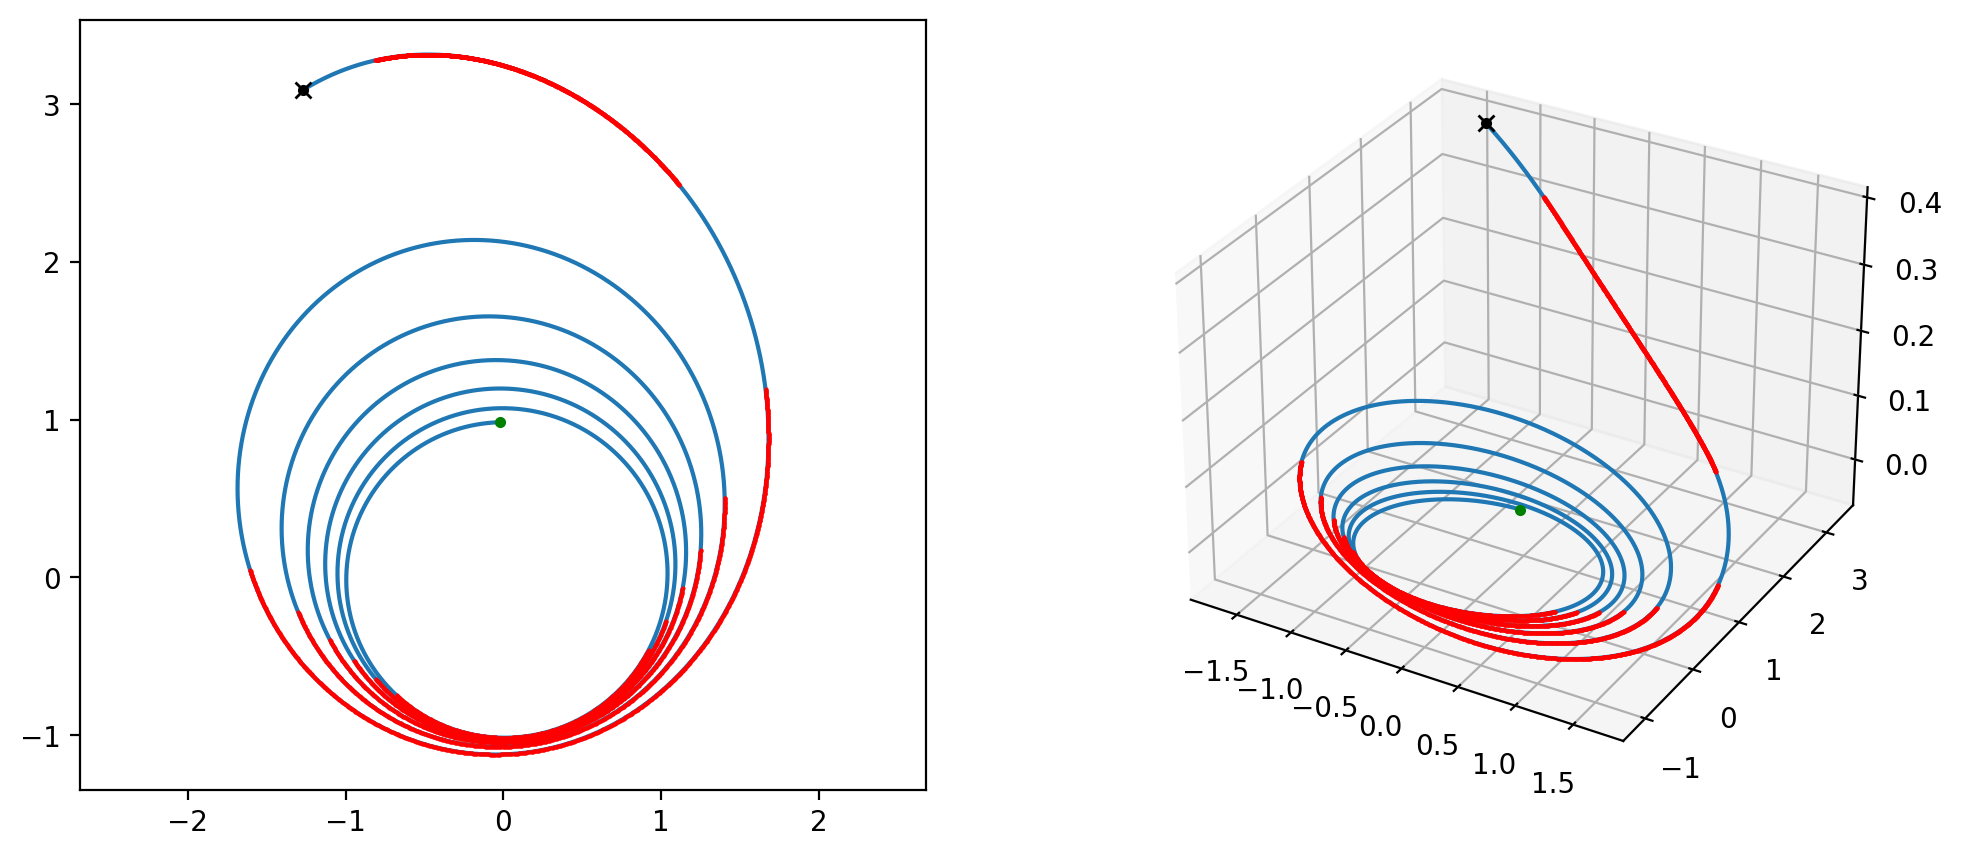

In [20]:
thrust_arc = sol_ax.u_tanh > 0
rv = sol.rv
rv_thrust = rv[:, thrust_arc]

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(rv[0], rv[1], '-')
ax1.plot(rv_thrust[0], rv_thrust[1], '.', ms=1, c='r')
ax1.plot(rv[0, 0], rv[1, 0], '.', c='g')
ax1.plot(rv[0, -1], rv[1, -1], '.', c='k')
ax1.plot(rv_t[0], rv_t[1], 'x', c='k')
ax1.axis('equal')

# plot 3d
ax2.plot(*rv[:3], '-')
ax2.plot(*rv_thrust[:3], '.', ms=1, c='r')
ax2.plot(*rv[:3, 0], '.', c='g')
ax2.plot(*rv[:3, -1], '.', c='k')
ax2.plot(*rv_t[:3], 'x', c='k')
plt.show()

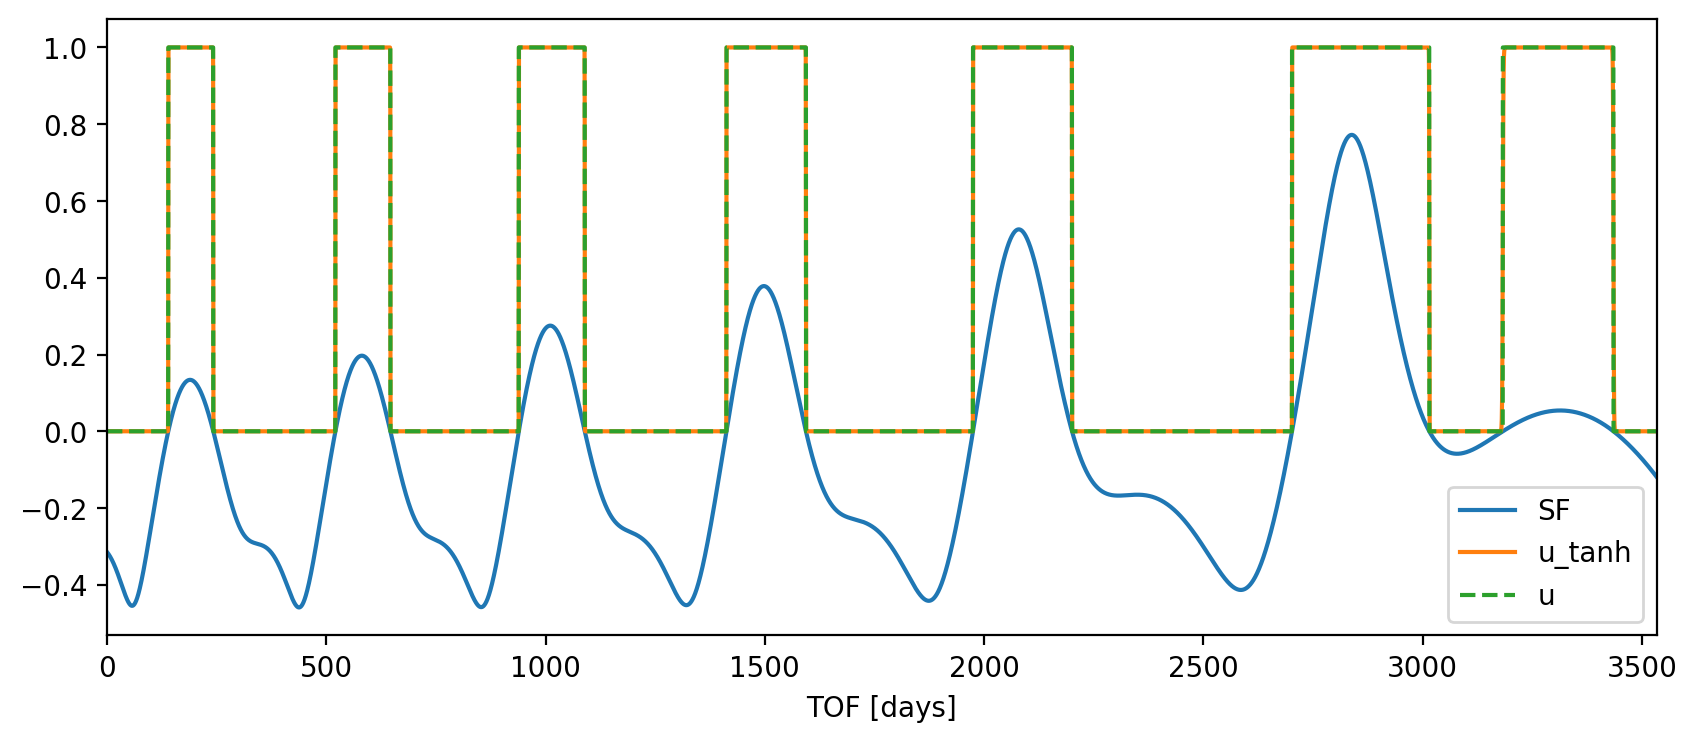

In [21]:
plt.figure(figsize=(10, 4))
t = sol_ax.t * TU / DAY2SEC
plt.plot(t, sol_ax.sf, label='SF')
plt.plot(t, sol_ax.u_tanh, label='u_tanh')
plt.plot(t, sol_ax.u, label='u', ls='--')
plt.xlim(t[0], t[-1])
plt.xlabel('TOF [days]')
plt.legend()

initial mass: 4000.0 kg
final mass: 2730.542951076665 kg


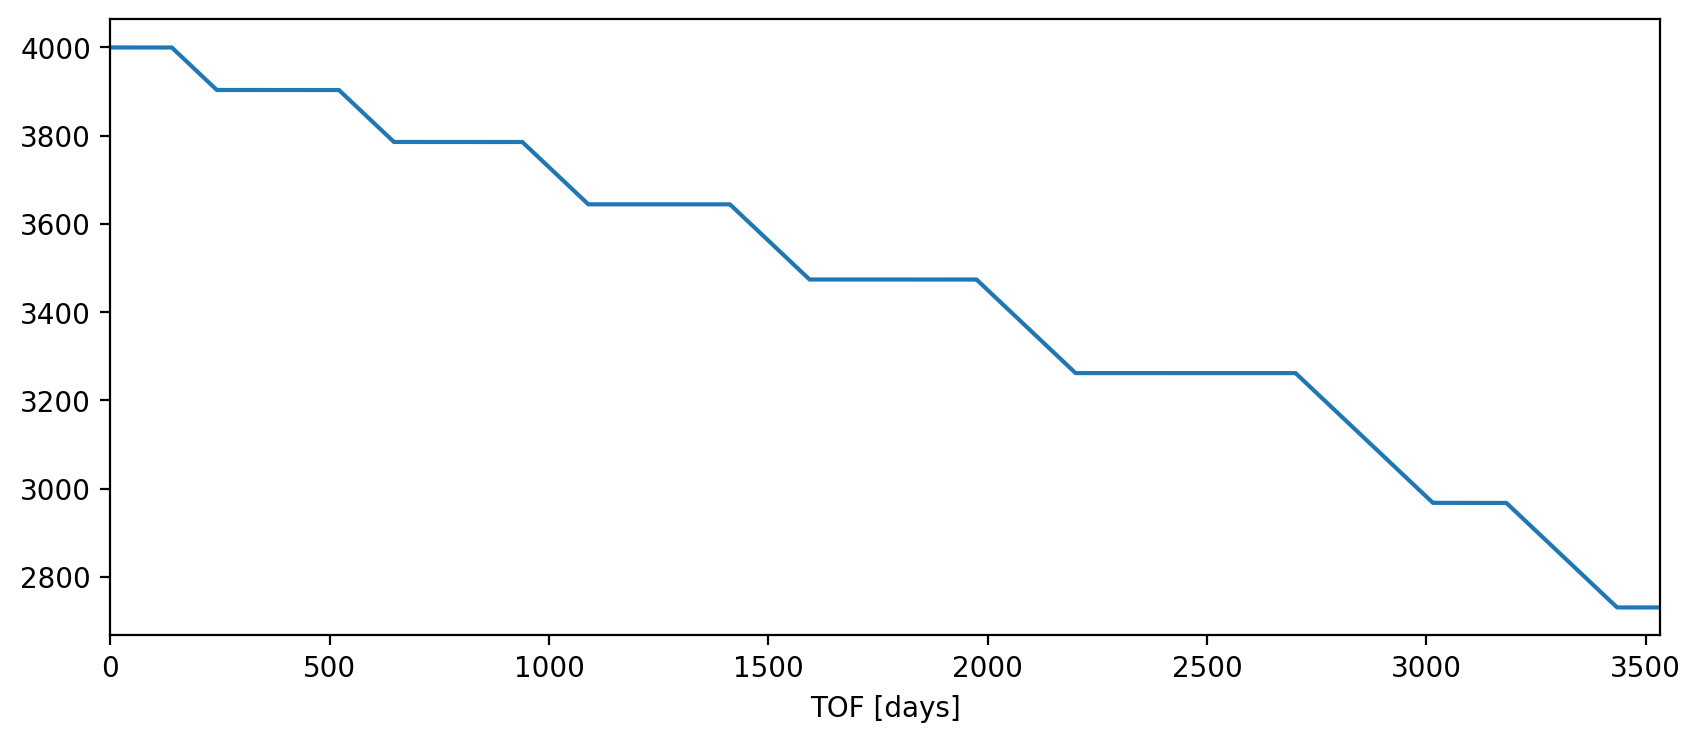

In [22]:
mass = sol.y[I.m].ravel() * MaU
plt.figure(figsize=(10, 4))
plt.plot(t, mass)
plt.xlim(t[0], t[-1])
plt.xlabel('TOF [days]')
print(f"initial mass: {mass[0]} kg")
print(f"final mass: {mass[-1]} kg")